# Deep Learning methods: BERT model 

## Jose Antonio Jijon Vorbeck

In this notebook, we will apply a BERT model to the tweets data set to perform a sentiment analysis. 

We will compare the results obtained from this model to those obtained using classical ML models.

BERT is a deep learning model that has een proven to give state-of-the art responses in natural Language Processing. BERT (Bidirectional Encoder Representations for Transformers) is a pre-trained model that has been developped by a team of Scientists at Google. It has been already trained with more than 250 million articles, including the english wikipedia and more sources.

BERT relies on a Transfomer, the attention mechanism part of the algorithm. A normal Transfore system consitns of an encoder to read the input, and a decoder to output any kind of information we which to obtain from the input. But since the goal of BERT is to generate a bidirectional representation language model, we will only need the encoder part of the system. 

The input to the encoder from BERT needs a series of tokenized vectors, which have to be in a specific format suitable fo the algorithm. Token embedding is a crucial part of the pre-processing done for this model. The [CLS] token is embedded at the beginning of each new sentence, and the [SEP] token is used at the end of the sentences, between two consecutive sentences.

We will make use of the BERT model by importing it from Tensorflow, we will be using KERAS, for a more suitable usage of the TF mechanism.

[BERT - Kaggle](https://www.kaggle.com/nayansakhiya/text-classification-using-bert)

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [3]:
# reading the already cleaned data, paths are those obtained from google collab
train_data = pd.read_csv('/content/drive/MyDrive/TFM/Data/TweetC_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/TFM/Data/TweetC_test.csv')
print(f'Training obs: {train_data.shape[0]}, and testing obs: {test_data.shape[0]}')

Training obs: 41156, and testing obs: 3798


In [4]:
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)

In [5]:
train_data.head()

,Corpus,label
0,advice talk neighbour family exchange phone nu...,4
1,coronavirus australia woolworth elderly disabl...,4
2,food stock panic food need stay calm stay safe,4
3,ready supermarket outbreak paranoid food stock...,0
4,news regionâs confirmed covid case came sulli...,4


In [6]:
y_train = train_data.iloc[:,1]
y_test = test_data.iloc[:,1]

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

X_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,0]

We will use the training dataset for both training and validation sets.

In [7]:
# 20% of the training data will be devoted to the validation dataset
train_text, validation_text, train_labels, validation_labels = train_test_split(X_train.to_numpy(), y_train.to_numpy(),test_size=0.2,random_state=0)

# making the test data into numpy formats
test_text = X_test.to_numpy()
test_labels = y_test.to_numpy()

In [8]:
# looking for empty strings or only numbers in a string
np.where(train_text == ' ')

#x = numpy.delete(x,(2), axis=1)

(array([], dtype=int64),)

In [9]:
print(f'The training data contains {len(train_text)} tweets, the validation contains {len(validation_text)} tweets')

The training data contains 32869 tweets, the validation contains 8218 tweets


In [10]:
train_labels

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]], dtype=uint8)

## Since the data we are using was already cleaned, and pre-processed, we will use now it directly to train a Neural Netwrok using BERT (Bidirectional Encoder R Trasformer) 

Now we will aplly more specific tasks more related to the BERT algorithm, like the BERT tokenization or the BERT model itself. We will be importing these tools from the internet.

In [11]:
# import BERT tokenization

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

Now we do more imports for SKlearn and TF, as well as the tokenization library

In [12]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 7.9MB/s 


In [13]:
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
#from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# keras
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Now we will import the BERT model from the hub.KerasLayer

In [14]:
# importing BERT Layer

m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

### Load the tokenizer functions

In [15]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

### Create the tokenization fuction

In [16]:
def bert_encode(texts, tokenizer, max_len=160):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

### And the Build model function

In [17]:
def build_model(bert_layer, max_len=160):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    #lay = Dense(128, activation='relu')(clf_output)
    #lay = Dropout(0.2)(lay)
    #lay = Dense(64, activation='relu')(lay)
    #lay = Dropout(0.2)(lay)
    out = Dense(5, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.TruePositives()])
    
    return model

### Create function for plotting train/validation losses and accuracies

In [18]:
def plot_loss_acc(acc, val_acc, loss, val_loss):

    fig, axs = plt.subplots(2)
    axs[0].plot(loss)
    axs[0].plot(val_loss)
    axs[0].set_title('Training and Validation Losses')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train', 'Val'])
    axs[1].plot(acc)
    axs[1].plot(val_acc)
    axs[1].set_title('Training and Validation Losses')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])
    fig.tight_layout()
    plt.show()

### Now we perform the text encoding

In [19]:
train_input = bert_encode(train_text, tokenizer, max_len = 160)
test_input = bert_encode(test_text, tokenizer, max_len = 160)
val_input = bert_encode(validation_text, tokenizer, max_len = 160)

train_labels = train_labels
test_labels = test_labels
val_labels = validation_labels

### Build the model

In [20]:
model = build_model(bert_layer, max_len = 160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Applying Early Stopping and saving the best model

In [25]:
# Save the model after every epoch.
saveBestModel = ModelCheckpoint('BERT_best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

### Finally we can fit the model

In [26]:
# running this in google collab because in the local server it takes much longer to complete.
train_history = model.fit(
    train_input, train_labels,
    validation_data=(val_input, val_labels),
    epochs=10,
    batch_size=50,
    callbacks=[earlyStopping]
)

Epoch 1/50
658/658 [==============================] - 1121s 2s/step - loss: 0.3570 - accuracy: 0.5658 - precision: 0.5744 - recall: 0.2576 - true_positives: 15411.0566 - val_loss: 0.3321 - val_accuracy: 0.6046 - val_precision: 0.5948 - val_recall: 0.3282 - val_true_positives: 25959.5215
Epoch 2/50
658/658 [==============================] - 1120s 2s/step - loss: 0.3170 - accuracy: 0.6314 - precision: 0.6091 - recall: 0.3787 - true_positives: 37913.0469 - val_loss: 0.3044 - val_accuracy: 0.6495 - val_precision: 0.6215 - val_recall: 0.4187 - val_true_positives: 50314.1562
Epoch 3/50
658/658 [==============================] - 1120s 2s/step - loss: 0.2897 - accuracy: 0.6760 - precision: 0.6329 - recall: 0.4501 - true_positives: 63453.9922 - val_loss: 0.2847 - val_accuracy: 0.6851 - val_precision: 0.6437 - val_recall: 0.4774 - val_true_positives: 76981.6953
Epoch 4/50
658/658 [==============================] - 1120s 2s/step - loss: 0.2700 - accuracy: 0.7071 - precision: 0.6533 - recall: 0.49

In [38]:
1120*2/60*10/60

6.222222222222223

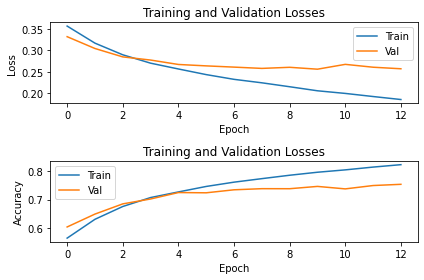

In [27]:
plot_loss_acc(train_history.history['accuracy'], train_history.history['val_accuracy'], train_history.history['loss'], train_history.history['val_loss'])

**Once we save the model, we can import it later for just the analysis, therefore not running the whole training process again.**

In [28]:
# # Para guardar y luego volver a utilizar el model, se siguen los pasos:

# # Guardar el Modelo
# # We won't need to manually save the model, since it is done as part of the training process, when we add the callback 'saveBestModel'
# model.save('path_to_my_model.h5')

# # Recrea exactamente el mismo modelo solo desde el archivo
# new_model = keras.models.load_model('path_to_my_model.h5')

### Evaluating the results of the trained model:

In [29]:
test_pred = model.predict(test_input)
test_pred = test_pred.round().astype(int)

In [30]:
# computing all the metric scores of the test
recall = metrics.recall_score(test_labels,test_pred, average='micro')
precision = metrics.precision_score(test_labels,test_pred, average='micro')
f1_score = metrics.f1_score(test_labels,test_pred, average='micro')
accuracy = metrics.accuracy_score(test_labels,test_pred)
loss = metrics.log_loss(test_labels,test_pred)

In [31]:
# printing the results:
print('Loss:',loss)
print('Accuracy:',accuracy)
print('Precision:',precision)
print('Recall:',recall)
print('f1 score:',f1_score)

Loss: 9.33146233659593
Accuracy: 0.7119894598155467
Precision: 0.7255639097744361
Recall: 0.7119894598155467
f1 score: 0.7187125947599414


## Only missing the function with a for-loop and a random number, so that it picks a random tweet, and obtains the encoded label vector, gets the index of the max, and transforms this to the actual sentiment, relying on the previous list:

`Extremely Negative`: 0

`Extremely Positive`: 1

`Negative`: 2

`Neutral`: 3

`Positive`: 4

In [39]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}

In [32]:
# transforming the pred vectors to its label:
test_pred_cat = np.zeros(test_pred.shape[0],)
test_labels_cat = np.zeros(test_pred.shape[0],)
for i in range(0,test_pred.shape[0],1):
  test_pred_cat[i] = test_pred[i].argmax()
  test_labels_cat[i] = test_labels[i].argmax()

test_pred_cat = test_pred_cat.astype(int)
test_labels_cat = test_labels_cat.astype(int)

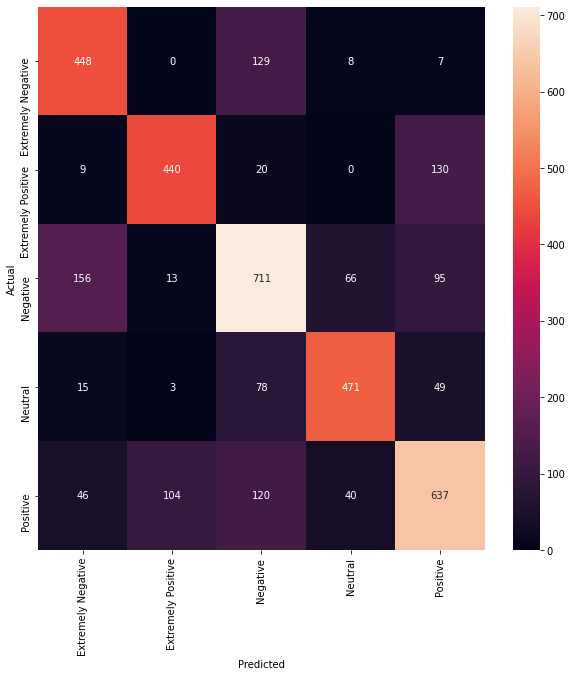

In [40]:
# confusion matrix

conf_mat = confusion_matrix(test_labels_cat, test_pred_cat)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [43]:
print(classification_report(test_labels_cat, test_pred_cat, target_names= labels.keys()))

                    precision    recall  f1-score   support

Extremely Negative       0.66      0.76      0.71       592
Extremely Positive       0.79      0.73      0.76       599
          Negative       0.67      0.68      0.68      1041
           Neutral       0.81      0.76      0.78       616
          Positive       0.69      0.67      0.68       947

          accuracy                           0.71      3795
         macro avg       0.72      0.72      0.72      3795
      weighted avg       0.72      0.71      0.71      3795



In [35]:
model.save('BERT_model.hdf5')